In [1]:
import sys
sys.path.append("../../")
from simulation_classes.flying_cars import FlyingCars
from simulation_classes.simulation_periodic import SimulationPeriodic
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd


In [35]:
"""
シミュレーションの基本的な設定
基本的には ./periodic_simulation.ipynbを参考にしている。
DRONE_NUMについてfor文を回すためのファイル
"""

TOTAL_TIME = 50
time_step = 0.5
simulation_steps = int(TOTAL_TIME / time_step)
scale_factor = 20 
legal_speed = 1.5
real_legal_speed = min(2, legal_speed) * scale_factor * 3.6
TOTAL_DISTANCE = 50
boundary_condition = "PERIODIC"
UPDATE_RULE = "parallel"
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 5 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい

# 先頭の車が前になるように置く(一番後ろの車はx=0でスタート)
def scatter_cars_around(total_distance, car_num, idx, should_scatter=False):
    delta = total_distance / car_num
    return total_distance - delta * (idx+1)

result_obj = {}

min_headway = 10 # 一番密度が高い時の車間距離を [m] で設定
drone_num_for_max_density = int(TOTAL_DISTANCE * scale_factor / min_headway) #その時のドローン台数
print(f"最大ドローン台数：{drone_num_for_max_density}台")
print(f"この設定だと法定速度は時速{real_legal_speed}km")
print(f"巡航距離は{TOTAL_DISTANCE * scale_factor /1000}kmです")
increment = 5

最大ドローン台数：100台
この設定だと法定速度は時速108.0km
巡航距離は1.0kmです


In [13]:
# シミュレーション用の関数

def simulate_with_parameters(**kwagrs):
    helly_params = kwagrs.get("helly_params")
    isRss = helly_params.get("isRss", False)
    simulation_list = []

    for i in range(int(drone_num_for_max_density / increment)):
        DRONE_NUM = (i+1) * increment
        if (DRONE_NUM >206):
            break
        cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                        ycor=0, 
                        v_0=0,
                        legal_speed=legal_speed, 
                        scale_factor=scale_factor,
                        drone_idx = i,
                        helly_params=helly_params,
                        )
                  for i in range(DRONE_NUM)]
        print(DRONE_NUM)
        simulation = SimulationPeriodic(
            TOTAL_TIME=TOTAL_TIME, 
            time_step=time_step, 
            scale_factor=scale_factor,
            drone_list=cars_list,
            TOTAL_DISTANCE=TOTAL_DISTANCE,
            UPDATE_RULE=UPDATE_RULE )
        simulation.run()
        simulation_list.append(simulation)
    
    return simulation_list


### ここからシミュレーション開始。

In [45]:
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor
front_car_brake = FRONT_BRAKE_REAL_WORLD / scale_factor
rear_brake_acc = 0.4
front_brake_acc = 0.8


helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "front_car_brake":front_brake_acc,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1,
    "isRss":False
  }
rss_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "front_car_brake": front_brake_acc,
    "rear_brake_acc":rear_brake_acc,
    "response_time":0.5, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1,
    "isRss":True,
  }
simulation_list_helly = simulate_with_parameters(helly_params = helly_params)
simulation_list_rss = simulate_with_parameters(helly_params = rss_params)

5
===PARALLEL実行===
FINISHED
10
===PARALLEL実行===
FINISHED
15
===PARALLEL実行===
FINISHED
20
===PARALLEL実行===
FINISHED
25
===PARALLEL実行===
FINISHED
30
===PARALLEL実行===
FINISHED
35
===PARALLEL実行===
FINISHED
40
===PARALLEL実行===
FINISHED
45
===PARALLEL実行===
FINISHED
50
===PARALLEL実行===
FINISHED
55
===PARALLEL実行===
FINISHED
60
===PARALLEL実行===
FINISHED
65
===PARALLEL実行===
FINISHED
70
===PARALLEL実行===
FINISHED
75
===PARALLEL実行===
FINISHED
80
===PARALLEL実行===
FINISHED
85
===PARALLEL実行===
FINISHED
90
===PARALLEL実行===
FINISHED
95
===PARALLEL実行===
FINISHED
100
===PARALLEL実行===
FINISHED
5
===PARALLEL実行===
FINISHED
10
===PARALLEL実行===
FINISHED
15
===PARALLEL実行===
FINISHED
20
===PARALLEL実行===
FINISHED
25
===PARALLEL実行===
FINISHED
30
===PARALLEL実行===
FINISHED
35
===PARALLEL実行===
FINISHED
40
===PARALLEL実行===
FINISHED
45
===PARALLEL実行===
FINISHED
50
===PARALLEL実行===
FINISHED
55
===PARALLEL実行===
FINISHED
60
===PARALLEL実行===
FINISHED
65
===PARALLEL実行===
FINISHED
70
===PARALLEL実行===
FINISHED
75
===PARALLEL実

### ここからは解析に入る

In [46]:
def analysis(**kwagrs):
    dataList = []
    simulation_list = kwagrs.get("simulation_list",[])
    isRss = kwagrs.get("isRss",False)
    model = "RSS" if isRss else "Helly"
    for simulation in simulation_list:
        cars = simulation.drone_list
        # 流量を計算する
        velocity_list = []
        for car in cars:
            snap_frame = int(simulation_steps * 0.95)
            velocity_list.append(car.v_xList[snap_frame])
        mean_velocity = np.mean(np.array(velocity_list)) * scale_factor

        # 密度：1km当たりの台数
        rho = len(cars) / (TOTAL_DISTANCE * scale_factor)  * 1000
        flow = rho * mean_velocity

        # プロット用に保存
        dataToSave = {
            "density":rho,
            "flow":flow,
            "mean_velocity":mean_velocity,
            "start_position":"unscattered",
            "drone_num":len(cars),
            "model":model
        }
        dataList.append(dataToSave)

    df = pd.DataFrame(dataList)
    return df


### グラフのVisualization

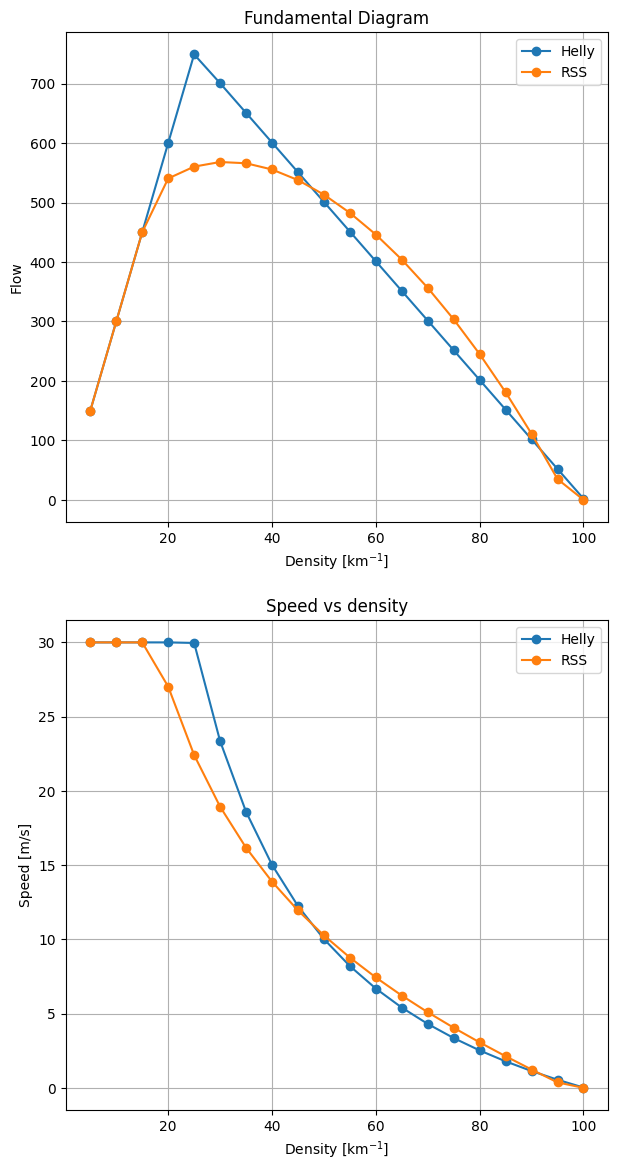

    density        flow  mean_velocity start_position  drone_num  model
0       5.0  150.000000      30.000000    unscattered          5  Helly
1      10.0  300.000000      30.000000    unscattered         10  Helly
2      15.0  450.000000      30.000000    unscattered         15  Helly
3      20.0  600.000000      30.000000    unscattered         20  Helly
4      25.0  749.046837      29.961873    unscattered         25  Helly
5      30.0  700.599789      23.353326    unscattered         30  Helly
6      35.0  650.704646      18.591561    unscattered         35  Helly
7      40.0  600.799809      15.019995    unscattered         40  Helly
8      45.0  550.896921      12.242154    unscattered         45  Helly
9      50.0  500.996443      10.019929    unscattered         50  Helly
10     55.0  451.096720       8.201759    unscattered         55  Helly
11     60.0  401.197078       6.686618    unscattered         60  Helly
12     65.0  351.297450       5.404576    unscattered         65

In [48]:
df_helly = analysis(simulation_list=simulation_list_helly)
df_rss = analysis(simulation_list=simulation_list_rss, isRss=True)

# 折れ線グラフを描画
plt.figure(figsize=(7, 14))
plt.subplot(2, 1, 1)
plt.plot(df_helly["density"], df_helly["flow"], marker='o', label="Helly")
plt.plot(df_rss["density"], df_rss["flow"], marker='o', label="RSS")
plt.xlabel(r'Density [km$^{-1}$]')
plt.ylabel('Flow')
plt.title('Fundamental Diagram')
plt.grid(True)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(df_helly["density"], df_helly["mean_velocity"], marker='o', label="Helly")
plt.plot(df_rss["density"], df_rss["mean_velocity"], marker='o', label="RSS")
plt.xlabel(r'Density [km$^{-1}$]')
plt.ylabel('Speed [m/s]')
plt.title('Speed vs density')
plt.grid(True)
plt.legend()
plt.show()

print(df_helly.head(20))
print(df_rss.head(20))

In [32]:
# ここからdebug開始 


In [33]:
# ここからdebug開始 
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor
front_car_brake = FRONT_BRAKE_REAL_WORLD / scale_factor

rss_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "lambda_1": 0.2,
    "lambda_2": 0,
    "d": 0.499,
    "T_des": 0.5,
    "isRss":True,
    "front_car_brake": front_car_brake,
    "response_time":0.5 #秒で入れる
  }

DRONE_NUM = 150
    
cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                ycor=0, 
                v_0=0,
                legal_speed=legal_speed, 
                scale_factor=scale_factor,
                drone_idx = i,
                helly_params=rss_params,
                )
          for i in range(DRONE_NUM)]
print(DRONE_NUM)
simulation = SimulationPeriodic(
  TOTAL_TIME=20, 
  time_step=time_step, 
  scale_factor=scale_factor,
  drone_list=cars_list,
  TOTAL_DISTANCE=TOTAL_DISTANCE,
  UPDATE_RULE=UPDATE_RULE )
simulation.run()

drones = simulation.drone_list
print(drones[0].v_xList)
print(len(drones[0].v_xList))

150
===PARALLEL実行===
FINISHED
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
41


In [49]:
# デバッグ用
DRONE_NUM = 20
response_time = 0.5
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor
front_brake_acc = 0.8
rear_brake_acc = 0.4
print(front_car_brake)

rss_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "front_car_brake": front_brake_acc,
    "rear_brake_acc":rear_brake_acc,
    "response_time":response_time, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1,
    "isRss":True,
  }

cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                     ycor=0, 
                     v_0=0,
                     legal_speed=legal_speed, 
                     scale_factor=scale_factor,
                     drone_idx = i,
                     helly_params=rss_params,
                     )
               for i in range(DRONE_NUM)]
simulation = SimulationPeriodic(
            TOTAL_TIME=TOTAL_TIME, 
            time_step=time_step, 
            scale_factor=scale_factor,
            drone_list=cars_list,
            TOTAL_DISTANCE=TOTAL_DISTANCE,
            UPDATE_RULE=UPDATE_RULE )
simulation.run()
print((simulation.drone_list[2].v_xList))

0.4
===PARALLEL実行===
FINISHED
[0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003, 1.0000000000000002, 1.0500000000000003, 1.1000000000000003, 1.1500000000000004, 1.2000000000000004, 1.2422652636376574, 1.2716909240937648, 1.2926497580464034, 1.3079528909613178, 1.3193361059685533, 1.3278879692001784, 1.3343290819801077, 1.3391691486336392, 1.34278839680706, 1.3454789934267208, 1.3474675291489167, 1.3489291603924547, 1.3499980385041617, 1.3507757772835713, 1.3513385263042776, 1.3517428282582764, 1.352030362619405, 1.3522316944162986, 1.3523691709837522, 1.3524591178298873, 1.3525134771023049, 1.352541014679212, 1.3525482005770113, 1.3525398461673772, 1.3525195627922615, 1.3524900905971136, 1.352453533831865, 1.3524115291651433, 1.3523653662419086, 1.3523160742982643, 1.3